### Eliminación de ruido

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)    

In [10]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [11]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) 
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [14]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) 
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0516
Epoch:2, Loss:0.0445
Epoch:3, Loss:0.0405
Epoch:4, Loss:0.0383
Epoch:5, Loss:0.0407
Epoch:6, Loss:0.0381
Epoch:7, Loss:0.0362
Epoch:8, Loss:0.0340
Epoch:9, Loss:0.0378
Epoch:10, Loss:0.0382


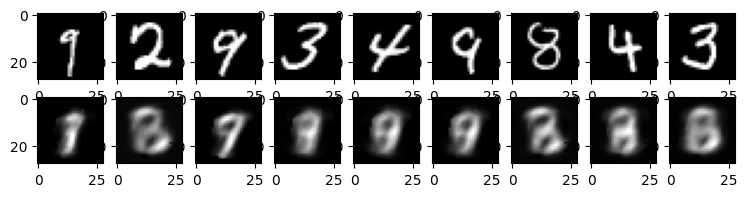

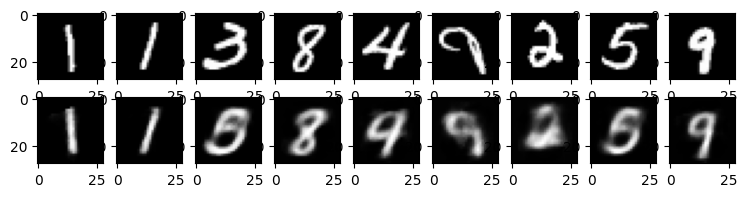

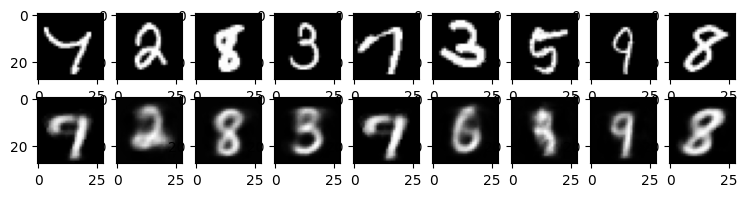

In [15]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) 
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28,28) 
        plt.imshow(item[0])

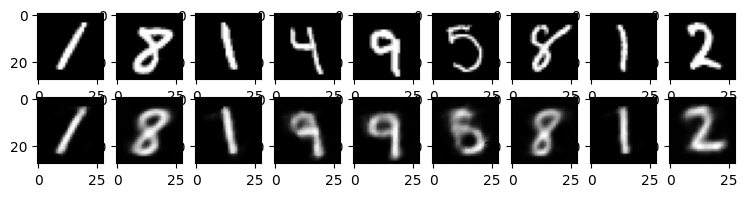

In [16]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img2 = img.reshape(-1, 28*28) 
        pred = model(img2)
        recon = pred[0].detach().numpy()
        recon2 = recon.reshape(-1, 28,28) 

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon2[0])

### Superresolución

In [17]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader_valid = torch.utils.data.DataLoader(mnist_data_valid, batch_size=64, shuffle=True)

In [18]:
def downsample_image(images, size):
    """
    Reduce la resolución de imágenes 28x28 a size x size
    size: 7 o 14
    """
    return F.interpolate(images, size=(size, size), mode='bilinear', align_corners=False)

In [19]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),                    # 7x7
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), nn.ReLU(), # 14x14
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1), nn.Sigmoid() # 28x28
        )
    def forward(self, x):
        return self.net(x)

model = SuperResolution()
input_size = 7

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for img, _ in data_loader:
        img_high = img  # 28x28 (objetivo)
        img_low = F.interpolate(img, size=(input_size, input_size), mode='bilinear')
        
        
        recon = model(img_low)
        loss = criterion(recon, img_high)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    
    
    outputs.append((img_low, img_high, recon))

Epoch:1, Loss:0.0300
Epoch:2, Loss:0.0239
Epoch:3, Loss:0.0246
Epoch:4, Loss:0.0217
Epoch:5, Loss:0.0193
Epoch:6, Loss:0.0242
Epoch:7, Loss:0.0228
Epoch:8, Loss:0.0206
Epoch:9, Loss:0.0241
Epoch:10, Loss:0.0206


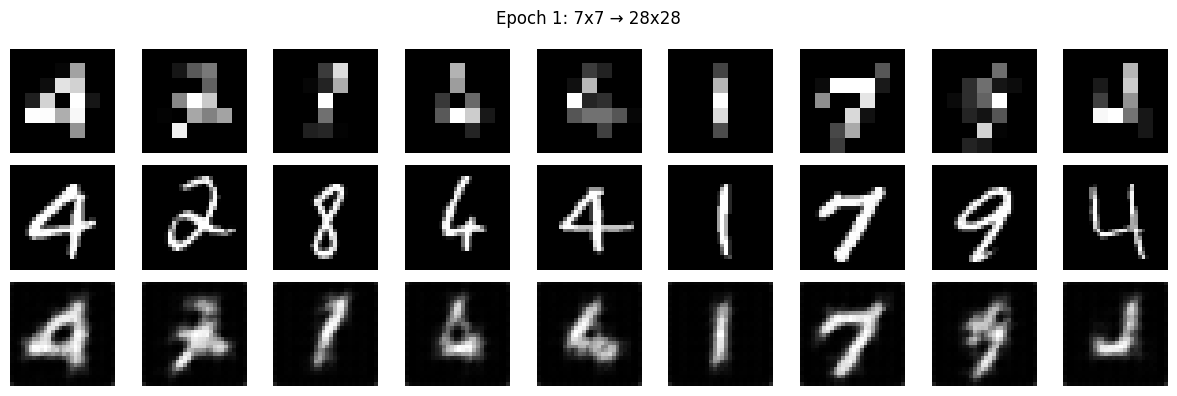

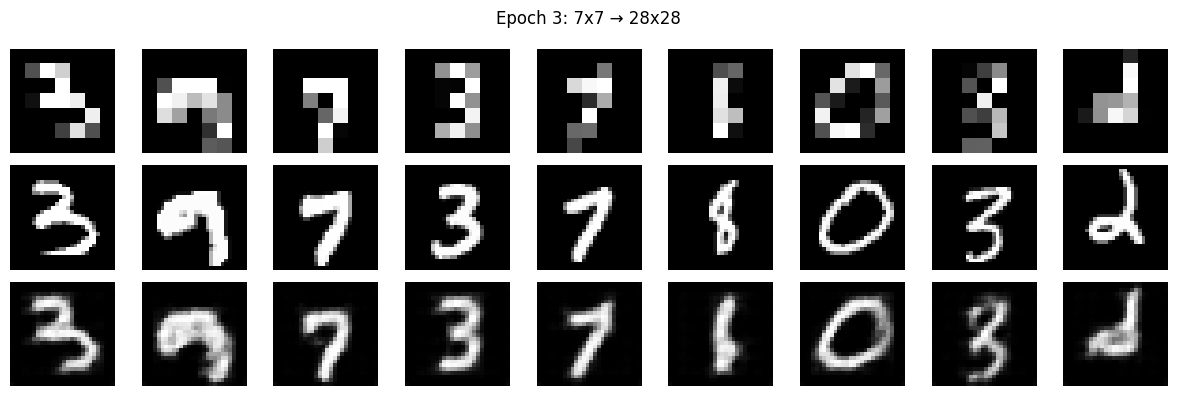

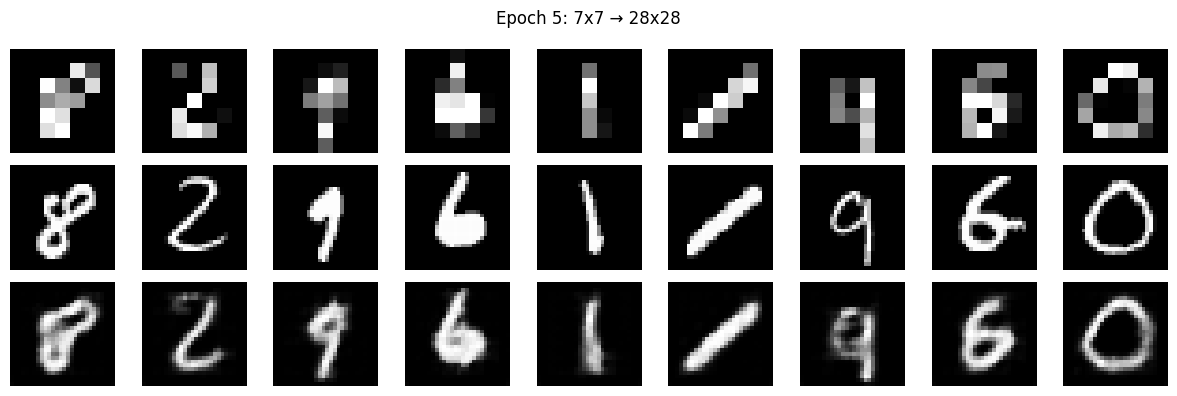

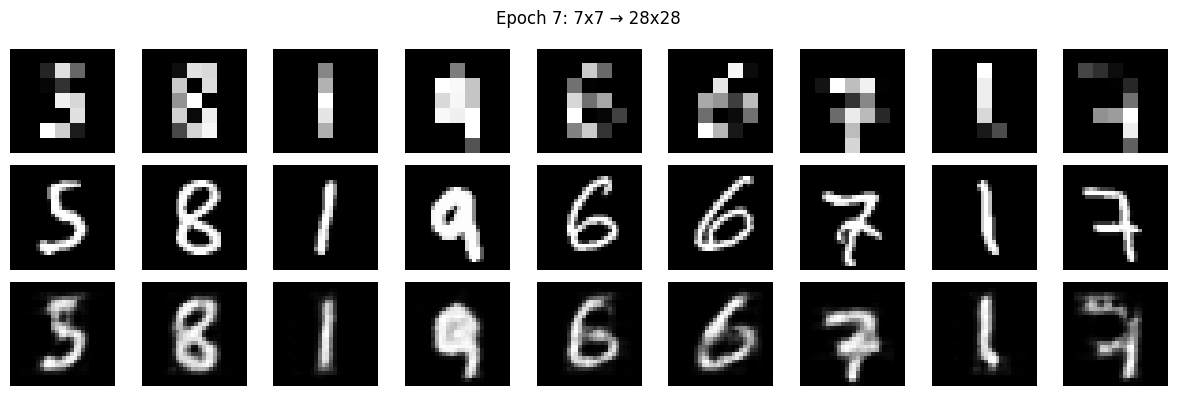

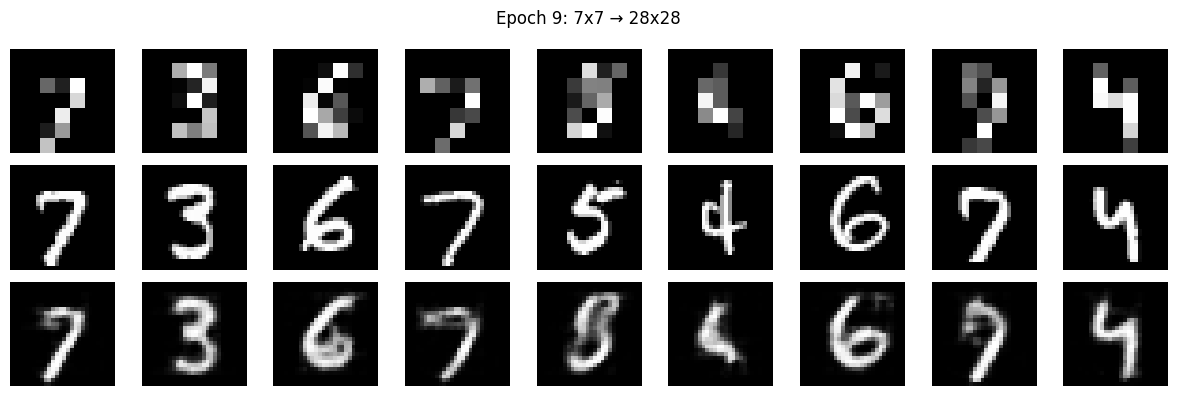

In [22]:
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(12, 4))
    plt.gray()
    
    img_low, img_high, recon = outputs[k]

    for i in range(9):
        plt.subplot(3, 9, i+1)
        plt.imshow(img_low[i][0].detach())
        plt.axis('off')
        
        plt.subplot(3, 9, 9+i+1)
        plt.imshow(img_high[i][0].detach())
        plt.axis('off')
        
        plt.subplot(3, 9, 18+i+1)
        plt.imshow(recon[i][0].detach())
        plt.axis('off')
    
    plt.suptitle(f'Epoch {k+1}: {input_size}x{input_size} → 28x28')
    plt.tight_layout()

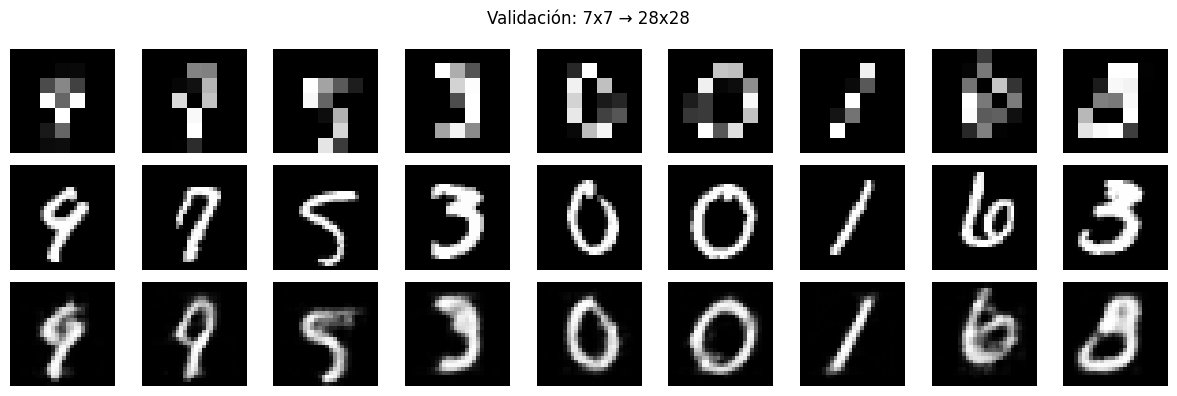

In [23]:
model.eval()
images, _ = next(iter(data_loader_valid))

plt.figure(figsize=(12, 4))
plt.gray()

for i in range(9):
    with torch.no_grad():
        img_high = images[i]
        img_low = F.interpolate(img_high.unsqueeze(0), size=(input_size, input_size), mode='bilinear')
        
        recon = model(img_low)[0][0]
        
        plt.subplot(3, 9, i+1)
        plt.imshow(img_low[0][0])
        plt.axis('off')
        
        plt.subplot(3, 9, i+10)
        plt.imshow(img_high[0])
        plt.axis('off')
        
        plt.subplot(3, 9, i+19)
        plt.imshow(recon)
        plt.axis('off')

plt.suptitle(f'Validación: {input_size}x{input_size} → 28x28')
plt.tight_layout()
plt.show()